# Ship Classification Using CNN Model for Maritime Applications Enhancement

This model is classification of the ship according to their type is of great importance in many aspects, including the security, military, and civil. This code use convelution nuaral network (CNN) to classify the ship images in the dataset of 6252 into 5 different category (Cargo,Military,Carrier,Cruise,Tanker). the code contain data pre-processing, building and training the model, and evaluating the model. you can visit the dataset we used from kaggle via this link: https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets.

For our model, we have followed the approach of “transfer learning." So, the code written here is an enhanced version of the code that was obtained from Kaggle, which has an accuracy of 80%. Our version of the code was examined and enhanced using different methods and techniques to finally achieve an accuracy of 91%. You can visit the code we obtained from Kaggle via this link: https://www.kaggle.com/code/tamsquare/c-nn-ship-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Exract images + traindl.csv + fixed_weights5.h5 from images.rar file
!pip install unrar
!unrar x /content/drive/MyDrive/images.rar

Streaming output truncated to the last 5000 lines.
Extracting  images/2829347.jpg                                            42%  OK 
Extracting  images/2829351.jpg                                            42%  OK 
Extracting  images/2829357.jpg                                            42%  OK 
Extracting  images/2829359.jpg                                            42%  OK 
Extracting  images/2829362.jpg                                            42%  OK 
Extracting  images/2829366.jpg                                            42%  OK 
Extracting  images/2829369.jpg                                            42%  OK 
Extracting  images/2829372.jpg                                            42%  OK 
Extracting  images/2829373.jpg                                            42%  OK 
Extracting  images/2829377.jpg                                            42%  OK 
Extracting  images/2829378.jp

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 9.0 MB/s eta 0:00:00


## Exploratory data analysis and preprocessing

In [ ]:
# Set seeds for reproducibility
tf.random.set_seed(30)
np.random.seed(30)

In [ ]:
train = pd.read_csv("traindl.csv")

In [ ]:
train.head()

image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2

In [ ]:
train.shape

(6252, 2)

<Axes: xlabel='category', ylabel='count'>

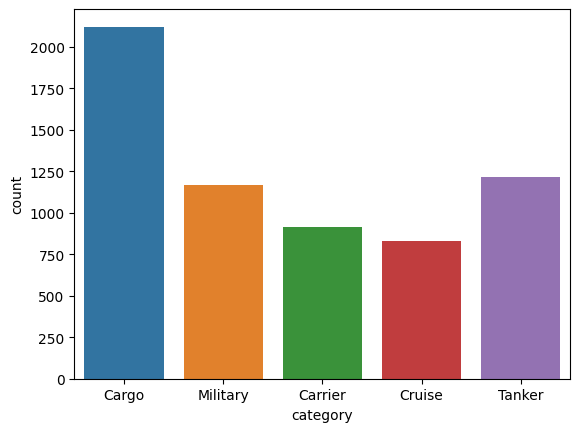

In [ ]:
# Mapping numerical ship category codes to corresponding names
ship_categories = {1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}
# Creating a count plot to visualize the distribution of ship categories in the training dataset
sns.countplot(x=train["category"].map(ship_categories))

In [ ]:
# Preprocessing images for training data
path = "images"  # Specify the directory containing the images
refactor_size = 96 # Set the target size for image resizing
resized_image_list = [] # List to store resized image arrays
all_paths = [] # List to store paths of all processed images

# Loop through the training data and resize each image to the specified target size
for i in range(len(train)):
    image_path = os.path.join(path, train["image"][i])
    img = tf.keras.utils.load_img(image_path, target_size=(refactor_size, refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)
    resized_image_list.append(imgarr)
    all_paths.append(image_path)

resized_image_list = np.asarray(resized_image_list) # Convert the list of resized images to a NumPy array

In [ ]:
# Displaying the count of each category
class_values = train["category"] - 1
class_values.value_counts()

0    2120
4    1217
1    1167
2     916
3     832
Name: category, dtype: int64

# Augmenting images

In [ ]:
# Data Augmentation using TensorFlow Sequential Model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.1), # Randomly rotate images by a small angle
])

# Apply data augmentation to the resized image list
augmented_images = data_augmentation(resized_image_list)

# visualizing

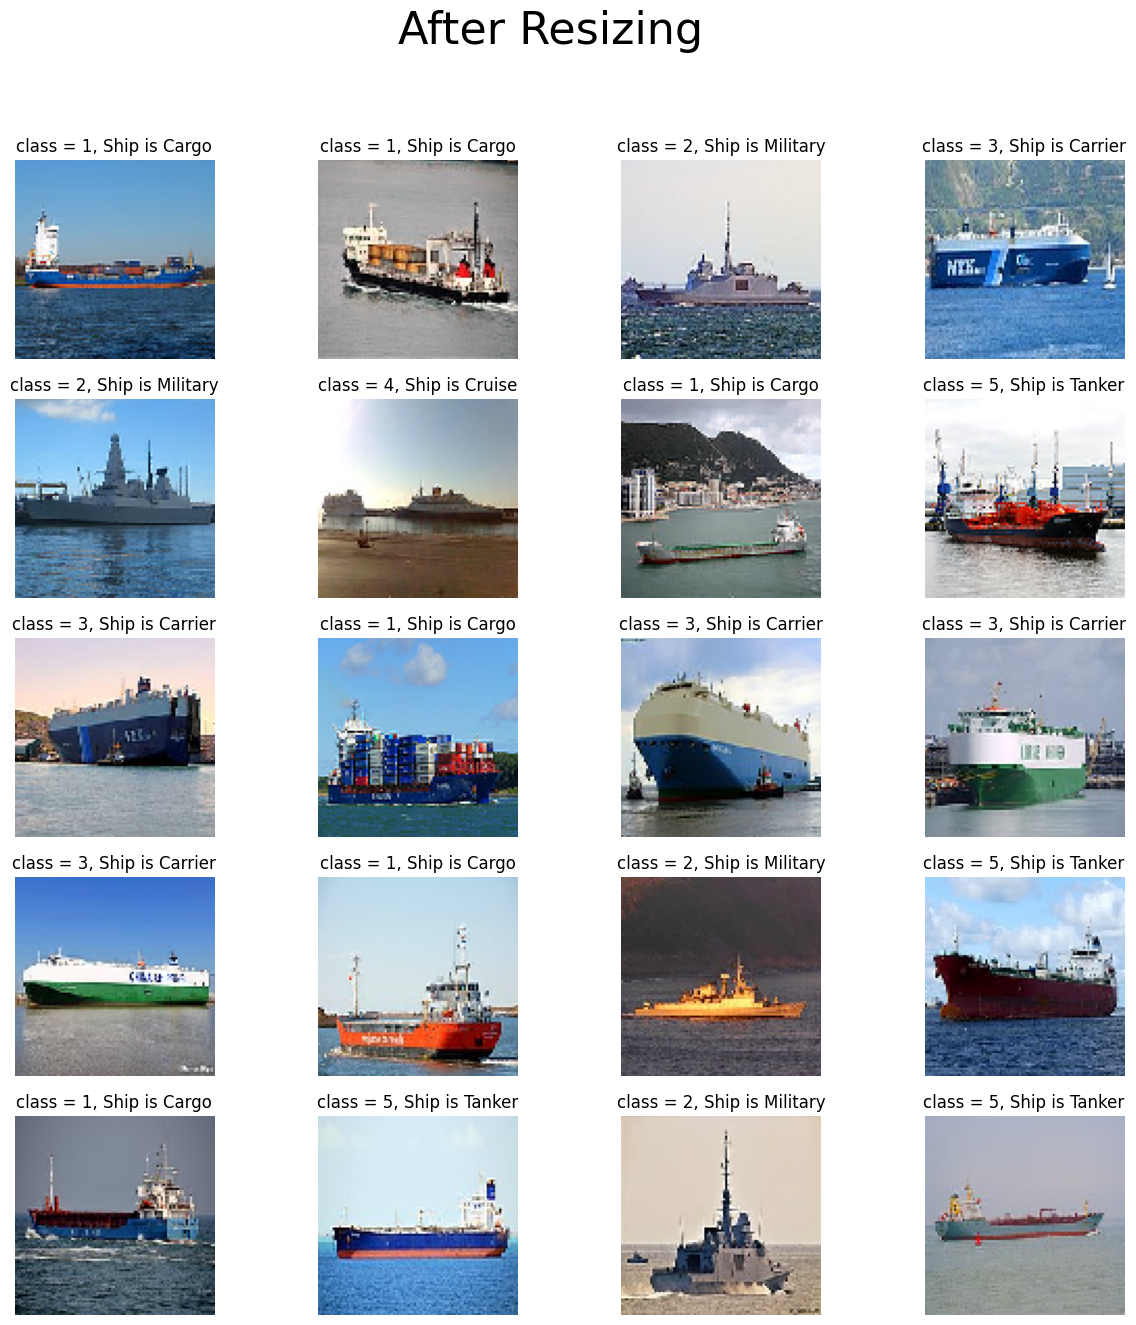

In [ ]:
# Visualization of Resized Images
nrow = 5 # Number of rows
ncol = 4 # Number of columns

# Create a new figure for visualizing the resized images
fig1 = plt.figure(figsize=(15, 15))
fig1.suptitle('After Resizing', size=32)

# Iterate through the first 20 resized images and display them in a subplot grid
for i in range(20):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(resized_image_list[i])
    plt.title('class = {x}, Ship is {y}'.format(x=train["category"][i], y=ship_categories[train["category"][i]]))
    plt.axis('Off')
    plt.grid(False)
plt.show()

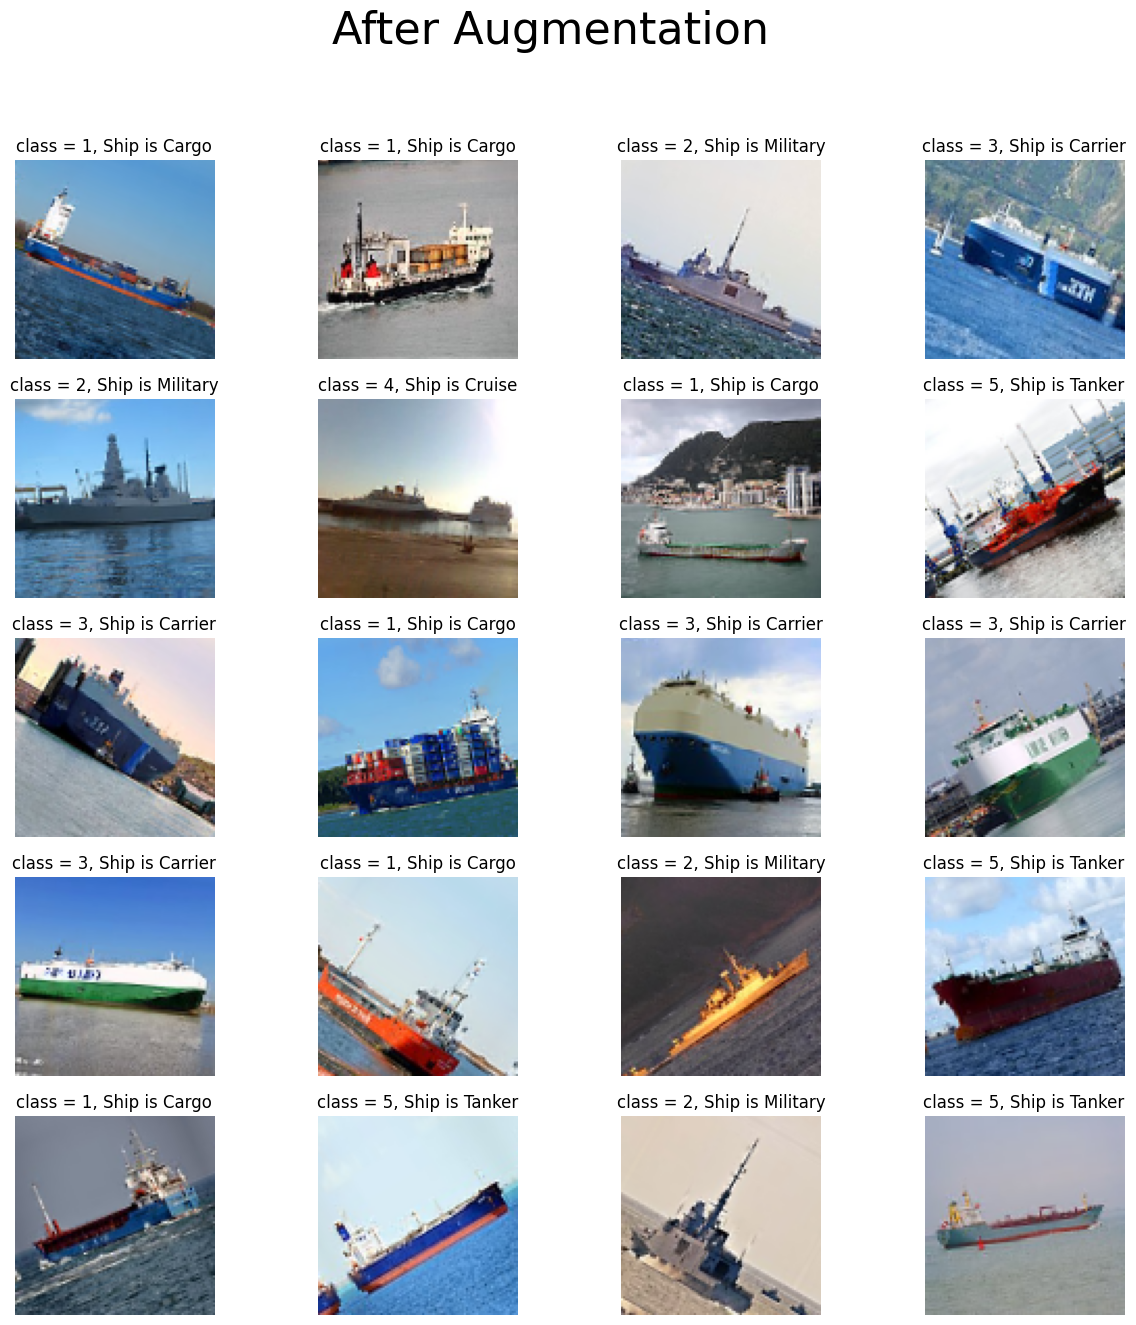

In [ ]:
# Visualization of Augmented Images
fig2 = plt.figure(figsize=(15, 15))
fig2.suptitle('After Augmentation', size=32)

# Display the augmented images along with their ship categories
for i in range(20):
    plt.subplot(nrow, ncol, i + 1)

    plt.imshow(augmented_images[i])
    plt.title('class = {x}, Ship is {y}'.format(x=train["category"][i], y=ship_categories[train["category"][i]]))
    plt.axis('Off')
    plt.grid(False)
plt.show()

In [ ]:
ship_categories = {0: 'Cargo', 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tanker'}

In [ ]:
augmented_images.shape

TensorShape([6252, 96, 96, 3])

# Seperating testing images

In [ ]:
# Further split the temporary data into validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(
    resized_image_list, class_values, test_size=0.1, random_state=30)

## Joining augmented and training and validation data

In [ ]:
x = np.concatenate((augmented_images.numpy(),X_temp),axis=0)
y = np.concatenate((class_values,y_temp),axis=0)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=30)
print(X_train.shape)
print(y_train.shape)

(9502, 96, 96, 3)
(9502,)


# Building The Model

In [ ]:
# If you want to get our training/validation/testing output, run the code and compile it but do not train the model
# do not forget to uncomment our stored weights (fixed_weights5.h5)

# Create a Convolutional Neural Network (CNN) using the Functional API

# Define the input layer and apply data augmentation to the input images
input_layer = tf.keras.Input(shape=(refactor_size, refactor_size, 3))
x = data_augmentation(input_layer)

# Stack multiple convolutional and pooling layers
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten the output for dense layers
x = layers.Flatten()(x)

# Add a dense layer
x = layers.Dense(128, activation='relu')(x)

# Define the output layer with 5 units (for 5 ship categories) and softmax activation
output_layer = layers.Dense(5, activation='softmax')(x)

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Access the path where the model weights are stored
#weights_path = '/content/drive/MyDrive/fixed_weights5.h5'

# Load the weights into the model
#model.load_weights(weights_path)

print(model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_26 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 46, 46, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 44, 44, 32)        9248      
                                                           

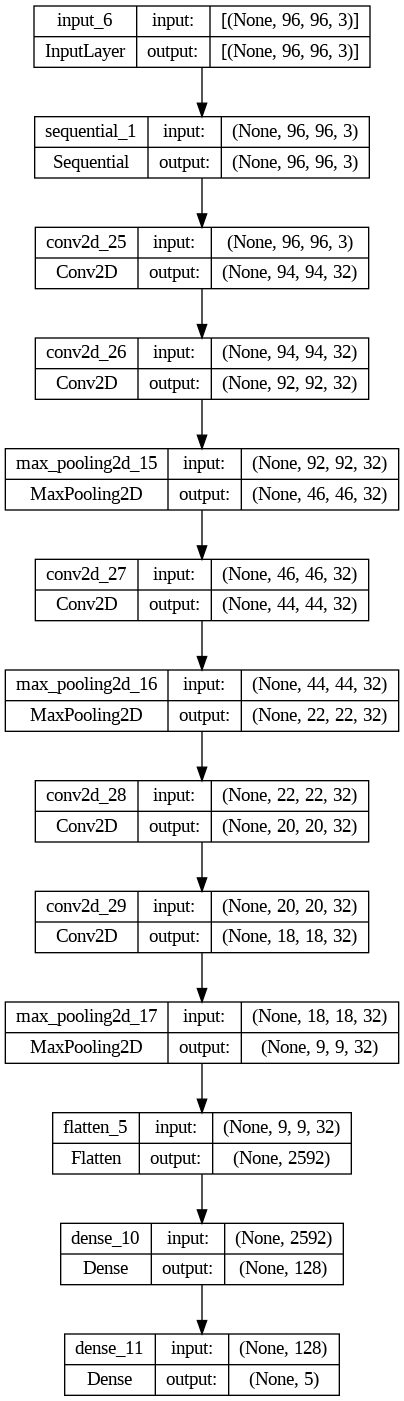

In [ ]:
# Plot the model
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes = True)

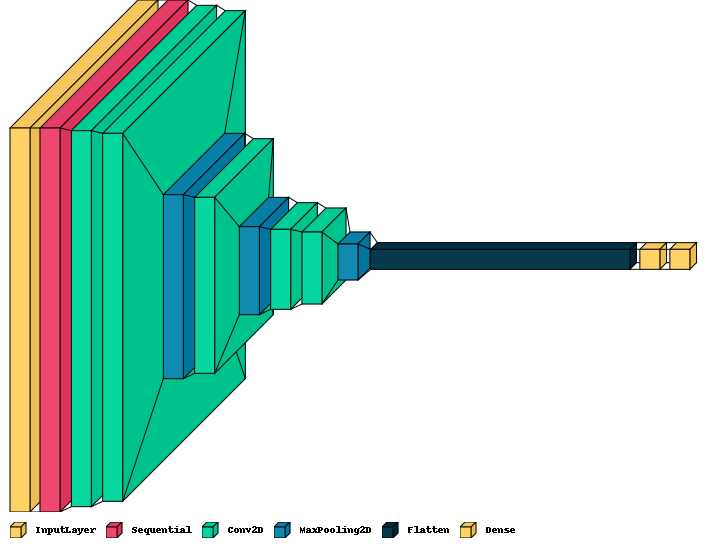

In [ ]:
# Visulaize the model
import visualkeras
visualkeras.layered_view(model, legend=True)

In [ ]:
# Model Checkpoint Callback where 'fixed_weights.h5' will store the model with the highest validation accuracy
checkpoint = ModelCheckpoint('/content/drive/MyDrive/fixed_weights5.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training and testing the model

In [ ]:
# ReduceLROnPlateau reduce the learning rate when the evaluation metric has stopped improving
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    batch_size = 32,
                    epochs=50, callbacks=[checkpoint,tf.keras.callbacks.ReduceLROnPlateau(patience = 5)])

Epoch 1/50
296/297 [============================>.] - ETA: 0s - loss: 1.3765 - accuracy: 0.4056
Epoch 1: val_accuracy improved from -inf to 0.50168, saving model to /content/drive/MyDrive/fixed_weights5.h5
297/297 [==============================] - 8s 21ms/step - loss: 1.3758 - accuracy: 0.4059 - val_loss: 1.1597 - val_accuracy: 0.5017 - lr: 0.0010
Epoch 2/50
295/297 [============================>.] - ETA: 0s - loss: 1.0779 - accuracy: 0.5469
Epoch 2: val_accuracy improved from 0.50168 to 0.57449, saving model to /content/drive/MyDrive/fixed_weights5.h5
297/297 [==============================] - 6s 19ms/step - loss: 1.0783 - accuracy: 0.5467 - val_loss: 0.9984 - val_accuracy: 0.5745 - lr: 0.0010
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.9455 - accuracy: 0.6098
Epoch 3: val_accuracy improved from 0.57449 to 0.61785, saving model to /content/drive/MyDrive/fixed_weights5.h5
297/297 [==============================] - 5s 18ms/step - loss: 0.9455 - accuracy: 0.6

In [ ]:
#This is when we saved the weights to fixed_weights5.h5 file
#weights_path = '/content/drive/MyDrive/fixed_weights5.h5'

# Save the model weights to the specified path
#model.save_weights(weights_path)

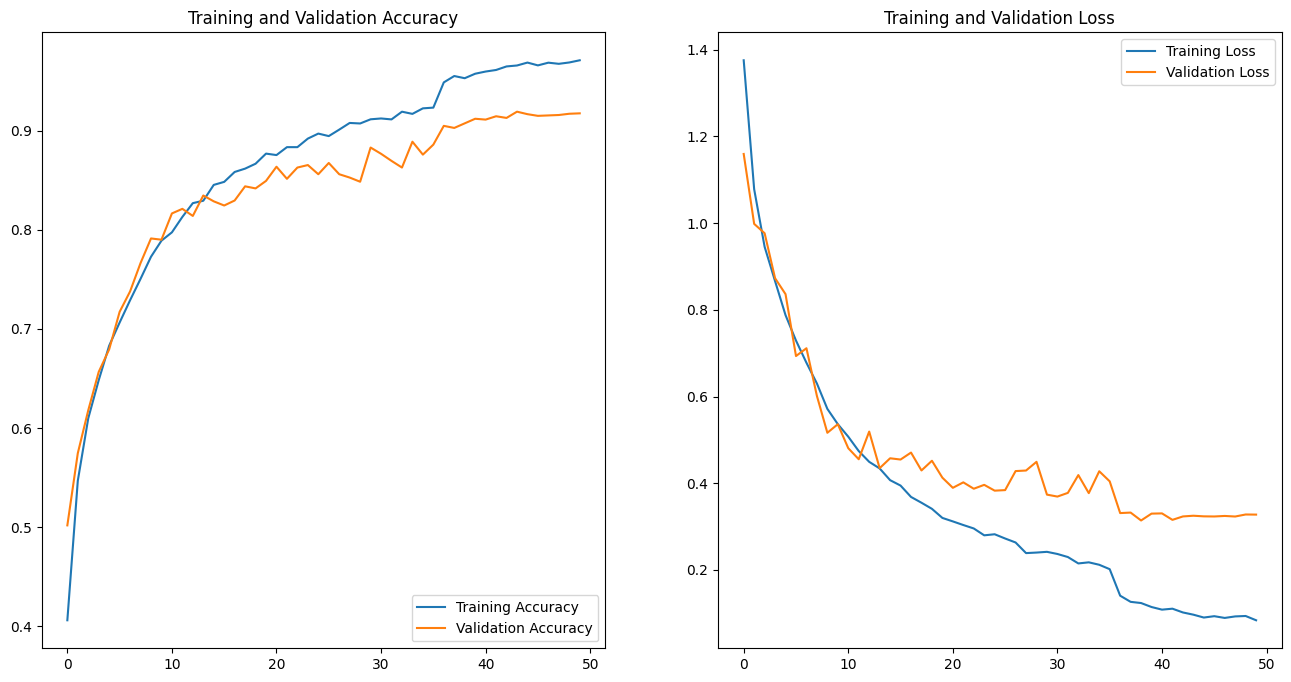

In [ ]:
# Visualizing Training and Validation Metrics

# Extracting training history metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training and validation accuracy
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#This is when we saved the entire model
# Save the entire model (including architecture, optimizer, and weights)
# model.save('/content/drive/MyDrive/fixed_weights5.h5')

# Load the entire model
best_model = load_model('/content/drive/MyDrive/fixed_weights5.h5')

In [ ]:
# Print the training accuracy for the best_model
test_loss, best_test_acc = best_model.evaluate(X_train, y_train, verbose=0)
print("Best Train Accuracy:", best_test_acc)

# Print the Validation accuracy for the best_model
test_loss, best_test_acc = best_model.evaluate(X_val, y_val, verbose=0)
print("Best ValAccuracy:", best_test_acc)

Best Train Accuracy: 0.9715849161148071
Best ValAccuracy: 0.9175084233283997


In [ ]:
# Test the model
best_predictions = best_model.predict(X_test)
best_predicted_classes = np.argmax(best_predictions, axis=1)

20/20 [==============================] - 0s 6ms/step


In [ ]:
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
# Print the testing accuracy for the best_model
print('Best Test accuracy:',accuracy_score(y_test,best_predicted_classes))

Best Test accuracy: 0.9185303514376997


In [ ]:
# Classification report
print(classification_report(y_test, best_predicted_classes, target_names=ship_categories.values()))

              precision    recall  f1-score   support

       Cargo       0.88      0.92      0.90       195
    Military       0.94      0.94      0.94       142
     Carrier       0.98      0.98      0.98        82
      Cruise       0.92      0.96      0.94        80
      Tanker       0.91      0.83      0.87       127

    accuracy                           0.92       626
   macro avg       0.93      0.93      0.93       626
weighted avg       0.92      0.92      0.92       626



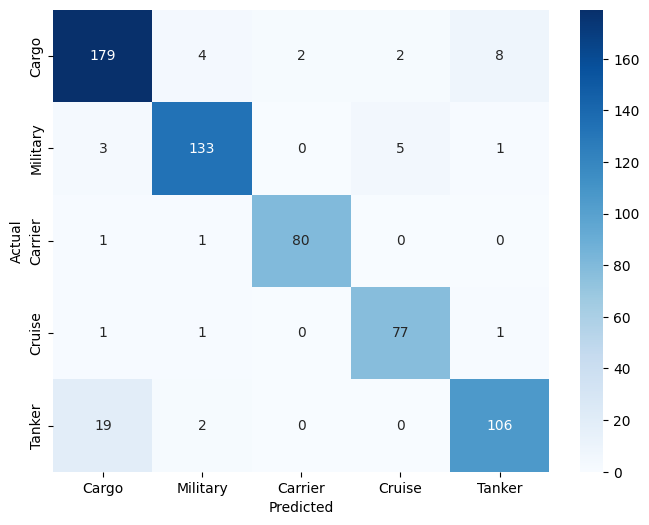

In [ ]:
# Confusion matrix
best_cm = confusion_matrix(y_test, best_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Blues', xticklabels=ship_categories.values(), yticklabels=ship_categories.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

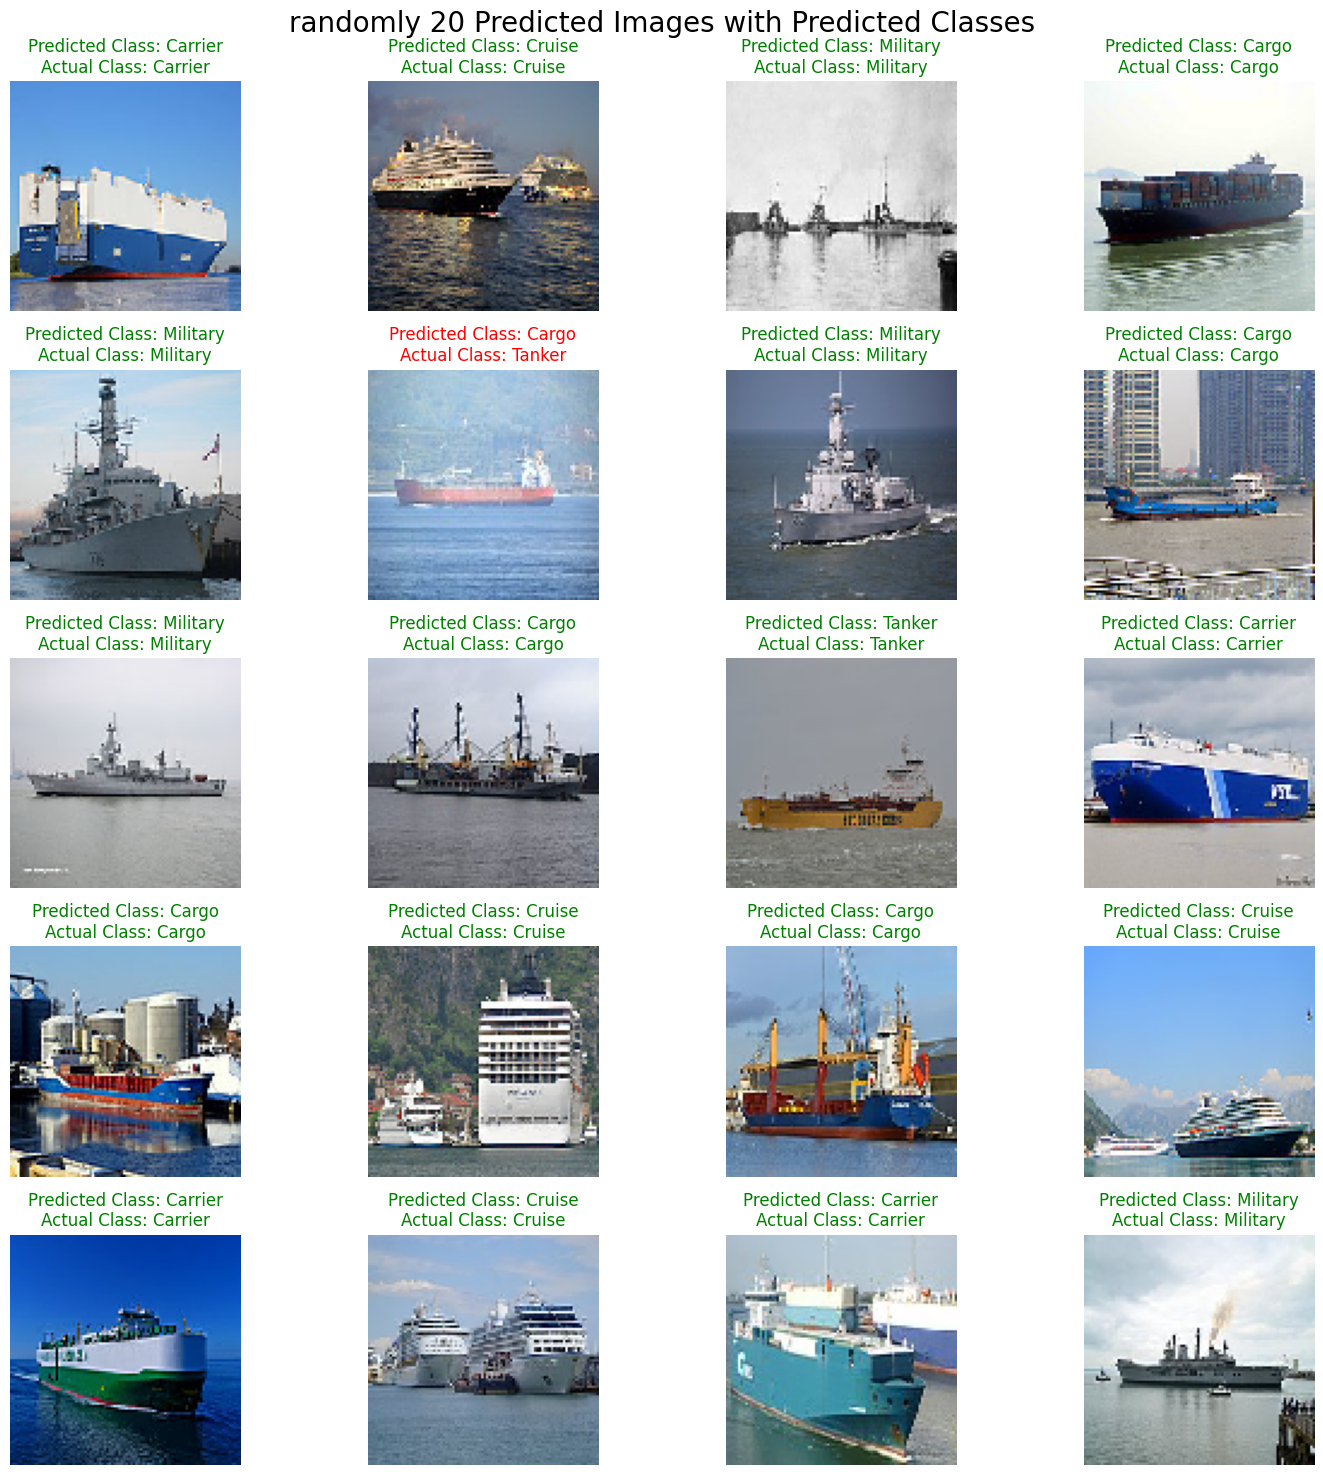

In [ ]:
# Display randomly selected 20 images from the test set along with their predicted and actual ship categories.

y_test = y_test.reset_index(drop=True)
plt.figure(figsize=(15, 15))
plt.suptitle('randomly 20 Predicted Images with Predicted Classes', size=20)
for i,num in enumerate(np.random.randint(0,len(y_test),size=20)):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[num])
    predicted_class_label = ship_categories[best_predicted_classes[num]]
    actual_class_label = ship_categories[y_test[num]]

    if best_predicted_classes[num] == y_test[num]:
        title_color = 'green'
    else:
        title_color = 'red'

    title = f'Predicted Class: {predicted_class_label}\nActual Class: {actual_class_label}'
    plt.title(title, color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()